In [1]:
import os
import errno
import numpy as np 
import xarray as xr
import deepcell
from deepcell.applications import MultiplexSegmentation

In [44]:
# load data
data_dir = '/data/segmentation/20200227_IF_Testing/melanoma/'
#data_dir = '/data/alex/2020325_test_image/'
data_dir = '/data/segmentation/20200227_IF_Testing/test_data/eliot'
data_dir = '/data/segmentation/20200209_CyCIF/'
data_dir = '/data/segmentation/datasets/20200226_Melanoma/20200627_Melanoma'
#data_dir = '/data/segmentation/datasets/20200114_cHL/20200522_cHL_job/'
#data_dir = '/data/segmentation/datasets/20200116_DCIS/20200618_DCIS'
#data_dir = '/data/segmentation/datasets/20191219_Eliot/20200616_Eliot_Screen2/'
#data_dir = '/data/segmentation/20200616_Model_Assessment'
# data_dir = '/data/selena/20200703_GI_test/'
# data_dir = '/data/segmentation/datasets/20200219_Roshan/20200720_Roshan/'
data_dir = '/data/segmentation/20200413_Human_Agreement'
data_dir = '/data/segmentation/20200820_figure_2_data/'
data_dir = '/data/segmentation/20200831_figure_4'

# data_dir = '/data/segmentation/datasets/20200526_COH_BC/20200730_COH_BC'
# data_dir = '/data/segmentation/datasets/20200624_graham_pancreas/'
# data_dir = '/data/segmentation/datasets/20200624_CODEX_Panc/20200823_CODEX_Panc'
# data_dir = '/data/segmentation/datasets/20200627_CODEX_CRC/20200831_CODEX_CRC'
# data_dir = '/data/segmentation/datasets/20200209_CyCIF/20200804_CyCIF_BRCA'
data_dir = '/data/segmentation/datasets/20200520_HIV'
data_dir = '/data/yunhao/'


In [4]:
test_data = np.load('/data/segmentation/20200831_figure_4/20200908_multiplex_test_no_resize_256x256.npz')
test_X = test_data['X']

In [80]:
cohort_xr = xr.open_dataarray(os.path.join(data_dir,'deepcell_input.xr'))
cohort_xr.shape

(1, 512, 512, 2)

In [44]:
summed = cohort_xr[:, :, :, 1].values + cohort_xr[:, :, :, 2].values + cohort_xr[:, :, :, 3].values

In [45]:
cohort_xr[:, :, :, 1] = summed

In [4]:
vals = np.zeros(list(cohort_xr.shape[:-1]) + [2])
vals[:, :, :, 0] = cohort_xr.values[..., 0]

In [18]:
vals = np.zeros(list(test_data.shape[:-1]) + [2])
vals[:, :, :, 0] = test_data[..., 0]

In [6]:
app = MultiplexSegmentation(use_pretrained_weights=False)

W0909 01:27:26.489074 140153429821248 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
# compartment
weights = "/data/models/20200619_production_updates/20200819_multiplex_normalized_512x512_compartment_deep_watershed.h5"

In [8]:
app.model.load_weights(weights)

In [99]:
output = app.predict(image=cohort_xr.values[:10], image_mpp=0.5, compartment='both', 
                     postprocess_kwargs_whole_cell={'maxima_threshold': 0.05, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.2,
                                                   'small_objects_threshold': 10,
                                                   'fill_holes_threshold': 10}, 
                     postprocess_kwargs_nuclear={'interior_threshold': 0.6, 'interior_model_smooth': 0,
                                                'maxima_model_smooth': 0})

In [20]:
output = app.predict(image=test_X, image_mpp=0.5, compartment='nuclear',  
                     postprocess_kwargs_nuclear={'interior_threshold': 0.5, 'interior_model_smooth': 0,
                                                'maxima_model_smooth': 0, 'pixel_expansion': 3,
                                                'maxima_threshold':0.05, 'maxima_model_smooth': 0,
                                  'radius':5,
                                  'small_objects_threshold':10,
                                  'fill_holes_threshold':10})

In [4]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            if np.sum(input_data[img, :, :, channel] > 0):
                percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                                [0, 95])
                rescaled_intensity = rescale_intensity(input_data[img, :, :, channel].astype('float32'),
                                                           in_range=(percentiles[0], percentiles[1]),
                                                           out_range='float32')
                RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [6]:
RGB_data = make_color_overlay(cohort_xr.values)

In [21]:
predicted_overlay = make_outline_overlay(RGB_data, output[:, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Predicted Overlay')

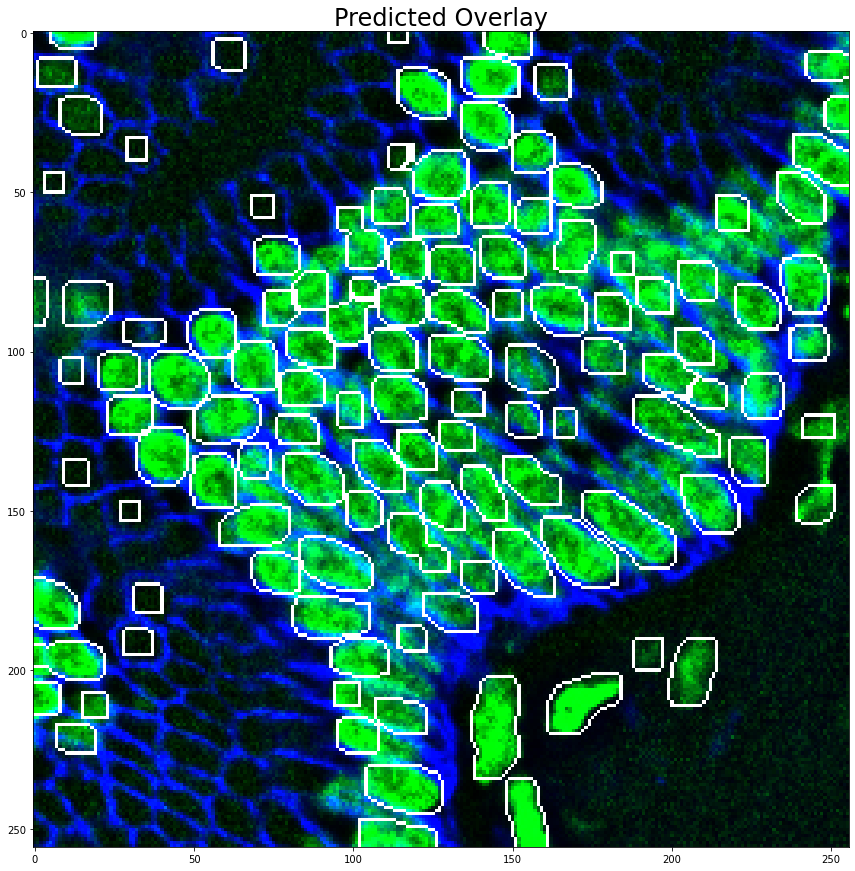

In [27]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 45
fig, axes = plt.subplots(figsize=(20,15))

axes.imshow(predicted_overlay[index, :, :, :], cmap=cmap)

axes.set_title('Predicted Overlay', fontsize=24)

In [14]:
segmentation_labels = xr.DataArray(output,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['nuclear']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels.to_netcdf(os.path.join(data_dir, "segmentation_labels_nuc.xr"), format="NETCDF3_64BIT")

## for whole-cell only model

In [77]:
weights = '/data/models/20200619_production_updates/20200827_multiplex_COH_normalized_512x512_deep_watershed.h5'

In [99]:
weights = '/data/models/20200619_production_updates/20200908_multiplex_3x_mibi_deep_watershed.h5'

In [35]:
weights = '/data/models/20200827_data_subset/20200827_multiplex_COH_normalized_512x512_subset_mibi.h5'

In [89]:
weights = '/data/models/20200619_production_updates/20200908_multiplex_deep_watershed.h5'

In [90]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256,256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

In [91]:
model.load_weights(weights)

In [10]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell_toolbox.processing import phase_preprocess
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
app = MultiplexSegmentation(use_pretrained_weights=False)

In [46]:
preprocessed = phase_preprocess(cohort_xr.values, 128)
resized = app._resize_input(preprocessed, image_mpp=0.5)
tiled_data, tile_info = tile_image(resized, model_input_shape=(256, 256), stride_ratio=1)

In [92]:
model_output = model.predict(tiled_data)
inner_distance, outer_distance, fgbg, pixelwise = app._untile_output(model_output, tile_info)

In [93]:
predictions = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[:, ..., 1:2]},
                                  maxima_threshold=0.05, maxima_model_smooth=0,
                                  interior_threshold=0.2,
                                  interior_model_smooth=2,
                                  radius=5,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10)

In [94]:
resized_predictions = app._resize_output(predictions, cohort_xr.shape)

In [86]:
RGB_data = make_color_overlay(cohort_xr[..., :].values)

In [95]:
predicted_overlay = make_outline_overlay(RGB_data, resized_predictions[:, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Predicted Overlay')

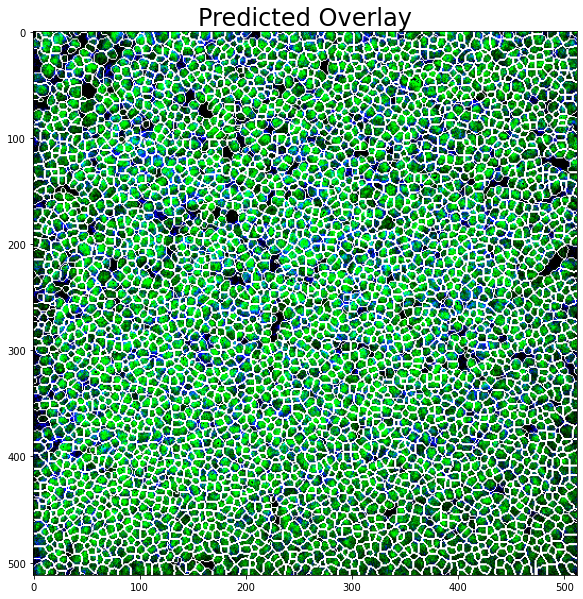

In [96]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 0
fig, axes = plt.subplots(figsize=(15,10))

axes.imshow(predicted_overlay[index, :, :, :], cmap=cmap)

axes.set_title('Predicted Overlay', fontsize=24)

In [82]:
new_vals = cohort_xr.values
mask = new_vals > 50
new_vals[mask] = 0
preprocessed = phase_preprocess(new_vals, 128)
resized = app._resize_input(preprocessed, image_mpp=1)
tiled_data, tile_info = tile_image(resized, model_input_shape=(256, 256), stride_ratio=1)

In [80]:
segmentation_labels = xr.DataArray(resized_predictions,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['whole_cell']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels.to_netcdf(os.path.join(data_dir, "segmentation_labels.xr"), format="NETCDF3_64BIT")

In [51]:
# for test data evaluation
np.savez_compressed('/data/segmentation/20200831_figure_4/predicted_labels_cell.npz', y=resized_predictions)